## **Spark Movie Recommendation**
In this notebook, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/).
<br><br>

### **Install Spark and import packages**
<br>

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ge

In [ ]:
!wget -q http://apache.forsale.plus/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!ls
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

sample_data  spark-2.4.7-bin-hadoop2.7.tgz


In [ ]:
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.7-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204kB 4.1MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [ ]:
!ls

sample_data  spark-2.4.7-bin-hadoop2.7	spark-2.4.7-bin-hadoop2.7.tgz


In [ ]:
spark.version

'2.4.7'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
os.environ['PYSPARK_PYTHON'] = 'python3'

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


##<br>**1. Data ETL and Data Exploration**
I'll load the datasets into spark dataframes, and explore the data.

<br>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving links.csv to links.csv
Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv
Saving tags.csv to tags.csv


In [ ]:
os.listdir()

['.config',
 'adc.json',
 'spark-2.4.7-bin-hadoop2.7.tgz',
 'links.csv',
 'tags.csv',
 'movies.csv',
 'spark-2.4.7-bin-hadoop2.7',
 'ratings.csv',
 'sample_data']

In [ ]:
movies_df = spark.read.load("./movies.csv", format='csv', header = True)
ratings_df = spark.read.load("./ratings.csv", format='csv', header = True)
links_df = spark.read.load("./links.csv", format='csv', header = True)
tags_df = spark.read.load("./tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
ratings_df.toPandas().isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

<br>There is no missing value in ratings (which I'll use to build the recommendation system later).
<br><br>

In [ ]:
rating_per_user = ratings_df.groupBy('userId').count().toPandas()
rating_per_movie = ratings_df.groupBy('movieId').count().toPandas()

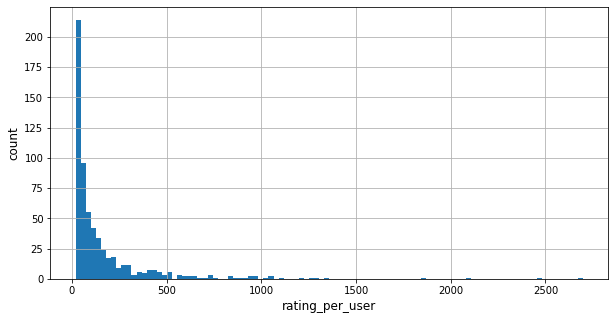

In [ ]:
ax = rating_per_user.hist('count', bins=100, figsize=(10,5))
plt.xlabel('rating_per_user', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('')
plt.show()

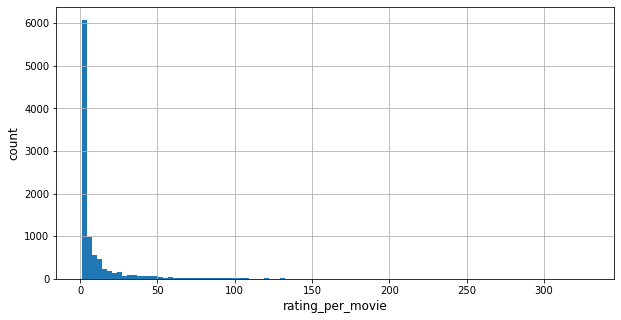

In [ ]:
ax = rating_per_movie.hist('count',bins=100,figsize=(10,5))
plt.xlabel('rating_per_movie', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('')
plt.show()

In [ ]:
tmp1 = rating_per_user['count'].min()
tmp2 = rating_per_movie['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(rating_per_movie['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies have only one rating'.format(tmp1, tmp2))

3446 out of 9724 movies have only one rating


<br> Every movie in ratings has at least one rating, and more than 1/3 movies have only one rating.

##**<br>2. Spark SQL and OLAP**
I'll use spark sql to analyze the datasets, and extract some information of interest.
<br><br>

In [ ]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

###<br>**2.1 The number of users that rated movies**
<br>

In [ ]:
spark.sql('\
            select count(distinct userid) as Number_of_users \
            from ratings \
          ').show()

+---------------+
|Number_of_users|
+---------------+
|            610|
+---------------+



###<br>**2.2 The total number of movies**
<br>

In [ ]:
spark.sql('\
            select count(*) as Number_of_movies \
            from movies \
          ').show()

+----------------+
|Number_of_movies|
+----------------+
|            9742|
+----------------+



###<br>**2.3 The number of movies rated by users and movies not rated**
<br>

In [ ]:
spark.sql('\
            select count(distinct movieid) as number_of_movies_rated \
            from ratings \
          ').show()

+----------------------+
|number_of_movies_rated|
+----------------------+
|                  9724|
+----------------------+



In [ ]:
# movies not rated by any user

spark.sql('\
            select title, genres \
            from movies \
            where movieid not in (select distinct movieid \
                                  from ratings)\
          ').show(truncate=False)

+--------------------------------------------+------------------------+
|title                                       |genres                  |
+--------------------------------------------+------------------------+
|Innocents, The (1961)                       |Drama|Horror|Thriller   |
|Niagara (1953)                              |Drama|Thriller          |
|For All Mankind (1989)                      |Documentary             |
|Color of Paradise, The (Rang-e khoda) (1999)|Drama                   |
|I Know Where I'm Going! (1945)              |Drama|Romance|War       |
|Chosen, The (1981)                          |Drama                   |
|Road Home, The (Wo de fu qin mu qin) (1999) |Drama|Romance           |
|Scrooge (1970)                              |Drama|Fantasy|Musical   |
|Proof (1991)                                |Comedy|Drama|Romance    |
|Parallax View, The (1974)                   |Thriller                |
|This Gun for Hire (1942)                    |Crime|Film-Noir|Th

### <br>**2.4 Movie genres and their frequency**
<br>

In [ ]:
spark.sql('\
            select genres as genre, \
                   count(*) as freq \
            from movies \
            group by genres \
          ').show()

+--------------------+----+
|               genre|freq|
+--------------------+----+
|Comedy|Horror|Thr...|  17|
|Adventure|Sci-Fi|...|   4|
|Action|Adventure|...|   6|
| Action|Drama|Horror|   1|
|Action|Animation|...|   2|
|Animation|Childre...|   2|
|Action|Adventure|...|  27|
|    Adventure|Sci-Fi|  15|
|Documentary|Music...|   1|
|Adventure|Childre...|   1|
| Adventure|Animation|   2|
| Musical|Romance|War|   1|
|Action|Adventure|...|   1|
|Adventure|Childre...|   2|
|Comedy|Crime|Horr...|   1|
|Crime|Drama|Fanta...|   1|
|Comedy|Mystery|Th...|   3|
|   Adventure|Fantasy|  13|
|Horror|Romance|Sc...|   1|
|Drama|Film-Noir|R...|   2|
+--------------------+----+
only showing top 20 rows



<br> The genres in the movies dataset were grouped together for each movie; in order to find out the basic genres, I'll need to split them first.
<br><br>

In [ ]:
spark.sql("\
            select genre, \
                   count(*) as freq \
            from (select explode(split(genres, '[\|]')) as genre \
                  from movies) \
            group by genre \
            order by genre \
          ").show()

+------------------+----+
|             genre|freq|
+------------------+----+
|(no genres listed)|  34|
|            Action|1828|
|         Adventure|1263|
|         Animation| 611|
|          Children| 664|
|            Comedy|3756|
|             Crime|1199|
|       Documentary| 440|
|             Drama|4361|
|           Fantasy| 779|
|         Film-Noir|  87|
|            Horror| 978|
|              IMAX| 158|
|           Musical| 334|
|           Mystery| 573|
|           Romance|1596|
|            Sci-Fi| 980|
|          Thriller|1894|
|               War| 382|
|           Western| 167|
+------------------+----+



###<br>**2.5 Movies for each genre**
<br>

In [ ]:
spark.sql("\
            select genre, collect_set(title) as list_of_movies \
            from \
                (select explode(split(genres, '[\|]')) as genre, title \
                 from movies) \
            group by genre \
          ").show(truncate=50)

+------------------+--------------------------------------------------+
|             genre|                                    list_of_movies|
+------------------+--------------------------------------------------+
|             Crime|[Stealing Rembrandt (Rembrandt) (2003), Innocen...|
|           Romance|[Vampire in Brooklyn (1995), Hysteria (2011), F...|
|          Thriller|[Element of Crime, The (Forbrydelsens Element) ...|
|         Adventure|[Ice Age: Collision Course (2016), Masters of t...|
|             Drama|[Airport '77 (1977), Meet John Doe (1941), Elem...|
|               War|[General, The (1926), Joyeux Noël (Merry Christ...|
|       Documentary|[The Barkley Marathons: The Race That Eats Its ...|
|           Fantasy|[Masters of the Universe (1987), Odd Life of Ti...|
|           Mystery|[Before and After (1996), Primal Fear (1996), O...|
|           Musical|[U2: Rattle and Hum (1988), Sword in the Stone,...|
|         Animation|[Ice Age: Collision Course (2016), Planes (2

##<br>**3. Spark ALS based approach for training model**
In order to train an ALS model, I'll first preprocess ratings data by removing useless columns, converting datatypes, and spliting into training and testing datasets. For the modeling part, I'll use 5-fold cross-validation to tune hyper-parameters and get the best model.
<br><br>

###**3.1 Data preprocessing**<br><br>

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movie_ratings = ratings_df.drop('timestamp')

In [ ]:
# convert data type

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn('userId', col('userId').cast(IntegerType())) \
                             .withColumn('movieId', col('movieId').cast(IntegerType())) \
                             .withColumn('rating', col('rating').cast(FloatType()))
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [ ]:
# create test and train set

(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [ ]:
training.count()

80721

In [ ]:
test.count()

20115

###**<br>3.2 Model tuning**
With the ALS model, I will use a grid search to find the optimal hyperparameters.<br><br>

In [ ]:
# import package

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
# create ALS model

als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [ ]:
# tune model using ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(als.maxIter, [5, 10, 20])
             .addGrid(als.rank, [5, 10, 20])
             .addGrid(als.regParam, [0.01, 0.05, 0.1, 0.5, 1])
             .build())

In [ ]:
# define evaluator as RMSE

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating')

In [ ]:
# build cross validation

cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, parallelism=3)

In [ ]:
# fit ALS model to training data

model = cv.fit(training)

In [ ]:
# extract the best model derived from cross-validation

best_model = model.bestModel

### <br> **3.3 Model evaluation and testing**
I'll evaluate the model performance with RMSE, get the best parameters, and make predictions with the best model on testing data.
<br><br>

In [ ]:
# generate predictions and evaluate using RMSE

predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
# print evaluation metrics and model parameters

print('RMSE = ' + str(rmse))
print('**Best Model**')
print(' Rank: ' + str(best_model.rank))
print(' MaxIter: ' + str(best_model._java_obj.parent().getMaxIter()))
print(' RegParam: ' + str(best_model._java_obj.parent().getRegParam()))

RMSE = 0.8812582280569093
**Best Model**
 Rank: 5
 MaxIter: 20
 RegParam: 0.1


In [ ]:
predictions.show()

+------+-------+------+-----------+
|userId|movieId|rating| prediction|
+------+-------+------+-----------+
|   372|    471|   3.0|  3.1670485|
|   182|    471|   4.5|  3.7028074|
|   462|    471|   2.5|  2.1688745|
|   520|    471|   5.0|  3.3757174|
|   273|    471|   5.0|  3.9188957|
|   216|    471|   3.0|  2.7152092|
|   608|    471|   1.5|  2.6704726|
|    44|    833|   2.0|  3.0110042|
|   599|    833|   1.5| 0.94272697|
|   609|    833|   3.0|   1.400319|
|   307|    833|   1.0|-0.23238185|
|   606|   1088|   3.0|   3.283702|
|    41|   1088|   1.5|   2.592773|
|   286|   1088|   3.5|  3.2935514|
|   387|   1088|   1.5|  2.7007537|
|   583|   1088|   3.5|  3.3109956|
|   188|   1088|   4.0|   3.775997|
|    42|   1088|   3.0|   4.050458|
|   325|   1238|   4.0|   4.158299|
|   268|   1238|   5.0|  3.4353104|
+------+-------+------+-----------+
only showing top 20 rows



### <br> **3.4 Alternative model testing using the full Movielens dataset**
I will use the full movielens dataset to further test the best model's performance.
<br><br>

In [ ]:
# get the dataset

id = "1XCoscHsVvNYZeW3bb3E1HFq5oWuZrcAq"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('fullratings.csv') 

In [ ]:
full_ratings = spark.read.load("fullratings.csv", format='csv', header = True)
full_ratings = full_ratings.drop('timestamp') \
                           .withColumn('userId', col('userId').cast(IntegerType())) \
                           .withColumn('movieId', col('movieId').cast(IntegerType())) \
                           .withColumn('rating', col('rating').cast(FloatType()))
full_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    307|   3.5|
|     1|    481|   3.5|
|     1|   1091|   1.5|
|     1|   1257|   4.5|
|     1|   1449|   4.5|
|     1|   1590|   2.5|
|     1|   1591|   1.5|
|     1|   2134|   4.5|
|     1|   2478|   4.0|
|     1|   2840|   3.0|
|     1|   2986|   2.5|
|     1|   3020|   4.0|
|     1|   3424|   4.5|
|     1|   3698|   3.5|
|     1|   3826|   2.0|
|     1|   3893|   3.5|
|     2|    170|   3.5|
|     2|    849|   3.5|
|     2|   1186|   3.5|
|     2|   1235|   3.0|
+------+-------+------+
only showing top 20 rows



In [ ]:
full_predictions = best_model.transform(full_ratings)
rmse = evaluator.evaluate(full_predictions)
print('RMSE = ' + str(rmse))

RMSE = 1.2021165775507732


In [ ]:
full_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   165|    148|   3.0| 2.5872278|
|   251|    471|   3.0|  4.091542|
|   593|    471|   3.0| 3.0790086|
|    81|    471|   3.5| 2.5761344|
|   332|    471|   2.0| 3.3240685|
|   336|    471|   4.0| 3.5903792|
|   417|    471|   3.0|  4.311777|
|   360|    471|   5.0| 3.3026936|
|   185|    471|   4.0| 3.6251512|
|   429|    471|   4.0| 3.9540513|
|   295|    471|   4.0| 3.9597058|
|   432|    471|   3.0| 3.1900973|
|   235|    471|   4.0| 3.7279177|
|   609|    471|   3.0| 3.0041342|
|   423|    471|   3.0|   3.23422|
|   485|    471|   4.0|  3.735363|
|     4|    471|   4.5| 3.5783687|
|   549|    471|   3.5| 2.1627443|
|   277|    471|   3.5| 2.8012571|
|   428|    471|   5.0| 2.3644247|
+------+-------+------+----------+
only showing top 20 rows



## <br>**4. Apply the model and see the performance**
First, I'll apply the best model to all ratings and get the predictions and RMSE. Next, I'll create some further applications with the model: making movie recommendations to a specified user, finding similar movies to a specified movie, and finding similar users to a specified user.
<br><BR>

### **4.1 Make predictions on all ratings**
<br>

In [ ]:
alldata = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print('RMSE = ' + str(rmse))

RMSE = 0.690610342781591


In [ ]:
alldata.registerTempTable('alldata')

In [ ]:
spark.sql('select * from alldata').show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0| 4.9127827|
|   133|    471|   4.0| 3.0119748|
|   597|    471|   2.0|  4.310061|
|   385|    471|   4.0|  3.301446|
|   436|    471|   3.0| 3.3731856|
|   602|    471|   4.0| 3.3053906|
|    91|    471|   1.0| 2.2817566|
|   409|    471|   3.0| 3.7006376|
|   372|    471|   3.0| 3.1670485|
|   599|    471|   2.5|  2.652343|
|   603|    471|   4.0| 2.8617496|
|   182|    471|   4.5| 3.7028074|
|   218|    471|   4.0| 3.8206005|
|   474|    471|   3.0| 3.0358596|
|   500|    471|   1.0| 1.8096226|
|    57|    471|   3.0| 3.4404275|
|   462|    471|   2.5| 2.1688745|
|   387|    471|   3.0| 3.1492805|
|   610|    471|   4.0| 3.4532576|
|   217|    471|   2.0| 2.5047612|
+------+-------+------+----------+
only showing top 20 rows



### <br> **4.2 Make movie recommendations to a specified user**
I'll use the recommendForAllUsers method of ALSModel to make personalized movie recommendations to users.
<br><br>

In [ ]:
from pyspark.sql.functions import explode

def recommend_movies_to_user(userId, num):
  '''
  userId: int
  num: int, the number of recommended movies
  '''
  recommended_movies_all = best_model.recommendForAllUsers(num) \
                                     .withColumn('recommendations', explode(col('recommendations'))) \
                                     .withColumn('movieId', col('recommendations')['movieId']) \
                                     .withColumn('prediction', col('recommendations')['rating']) \
                                     .select('userId', 'movieId', 'prediction')
  return recommended_movies_all.filter(col('userId')==userId).join(movies_df, 'movieId').select('movieId', 'title', 'genres', 'prediction')

In [ ]:
# recommend 10 movies to user with id 575

result = recommend_movies_to_user(575, 10)
result.show(truncate=False)

+-------+-------------------------------+--------------------+----------+
|movieId|title                          |genres              |prediction|
+-------+-------------------------------+--------------------+----------+
|89904  |The Artist (2011)              |Comedy|Drama|Romance|5.963774  |
|59018  |Visitor, The (2007)            |Drama|Romance       |5.760055  |
|60943  |Frozen River (2008)            |Drama               |5.760055  |
|51931  |Reign Over Me (2007)           |Drama               |5.612236  |
|100714 |Before Midnight (2013)         |Drama|Romance       |5.5894246 |
|7841   |Children of Dune (2003)        |Fantasy|Sci-Fi      |5.564225  |
|82     |Antonia's Line (Antonia) (1995)|Comedy|Drama        |5.5431123 |
|3022   |General, The (1926)            |Comedy|War          |5.4890723 |
|3379   |On the Beach (1959)            |Drama               |5.4671335 |
|86320  |Melancholia (2011)             |Drama|Sci-Fi        |5.412531  |
+-------+-----------------------------

In [101]:
# recommend 10 movies to user with id 125

result = recommend_movies_to_user(125, 10)
result.show(truncate=False)

+-------+-----------------------------------------------------------------------+---------------------+----------+
|movieId|title                                                                  |genres               |prediction|
+-------+-----------------------------------------------------------------------+---------------------+----------+
|40     |Cry, the Beloved Country (1995)                                        |Drama                |5.42651   |
|3379   |On the Beach (1959)                                                    |Drama                |5.3658113 |
|4495   |Crossing Delancey (1988)                                               |Comedy|Romance       |5.1653194 |
|8235   |Safety Last! (1923)                                                    |Action|Comedy|Romance|5.1653194 |
|43376  |Sophie Scholl: The Final Days (Sophie Scholl - Die letzten Tage) (2005)|Drama|War            |5.1653194 |
|6201   |Lady Jane (1986)                                                       

### <br> **4.3 Find similar movies to a specified movie**
Since the ALS model stores item features and user features, I could use these features to compute cosine similarity, so as to find similar movies/users to any specified movie/user.
<br><br>

In [ ]:
movies_df = movies_df.withColumn('movieId', col('movieId').cast(IntegerType()))
df_movies = movies_df.toPandas()
item_factors = best_model.itemFactors.toPandas()

In [ ]:
def similar_movies(movieId, num):
  '''
  movieId: int
  num: int, the number of similar movies
  '''
  try:
    features = item_factors[item_factors.id == movieId].iloc[0, 1]
  except:
    return 'There is no movie with id ' + str(movieId)
  
  similarities = np.empty((item_factors.shape[0], 2))
  for i in range(item_factors.shape[0]):
    id = item_factors.iloc[i, 0]
    numerator = np.dot(features, item_factors.iloc[i, 1])
    denominator = np.linalg.norm(features) * np.linalg.norm(item_factors.iloc[i, 1])
    cos_similarity = numerator / denominator
    similarities[i] = [id, cos_similarity]
  
  df_similarities = pd.DataFrame(similarities, columns = ['movieId', 'similarity']) \
                      .astype({"movieId": int, "similarity": float}) \
                      .sort_values(by = 'similarity', ascending = False)
  return df_similarities.iloc[1:num+1, :].merge(df_movies, on = 'movieId')

In [ ]:
# 10 movies most similar to the movie with id 165

similar_movies(165, 10)

,movieId,similarity,title,genres
0,82041,0.998443,"Loved Ones, The (2009)",Horror
1,161,0.996863,Crimson Tide (1995),Drama|Thriller|War
2,5409,0.996758,Rapid Fire (1992),Action
3,88672,0.996424,Our Idiot Brother (2011),Comedy
4,2504,0.996395,200 Cigarettes (1999),Comedy|Drama
5,69805,0.996370,"Librarian, The: The Curse of the Judas Chalice...",Action|Adventure|Fantasy
6,93287,0.996300,"Big Year, The (2011)",Comedy
7,1580,0.996072,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi
8,5523,0.995853,"Adventures of Pluto Nash, The (2002)",Action|Adventure|Comedy|Sci-Fi
9,380,0.995567,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller


In [ ]:
df_movies[df_movies.movieId == 165]

,movieId,title,genres
138,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller


In [ ]:
# 10 movies most similar to the movie with id 471

similar_movies(471, 10)

,movieId,similarity,title,genres
0,2249,0.998051,My Blue Heaven (1990),Comedy
1,4873,0.996984,Waking Life (2001),Animation|Drama|Fantasy
2,4774,0.995333,Big Trouble (2002),Comedy|Crime
3,3831,0.990300,Saving Grace (2000),Comedy
4,114060,0.987871,The Drop (2014),Crime|Drama|Thriller
5,14,0.987774,Nixon (1995),Drama
6,79299,0.986759,"No. 1 Ladies' Detective Agency, The (2008)",Comedy|Crime|Mystery
7,79536,0.986759,Hellsinki (Rööperi) (2009),Crime
8,26900,0.986759,"Last Wedding, The (Kivenpyörittäjän kylä) (1995)",Comedy|Drama
9,54796,0.986759,2 Days in Paris (2007),Comedy|Drama|Romance


In [ ]:
df_movies[df_movies.movieId == 471]

,movieId,title,genres
409,471,"Hudsucker Proxy, The (1994)",Comedy


### <br> **4.4 Find similar users to a specified user**
<br>

In [ ]:
user_factors = best_model.userFactors.toPandas()

def similar_users(userId, num):
  try:
    features = user_factors[user_factors.id == userId].iloc[0, 1]
  except:
    return 'There is no user with id ' + str(userId)
  
  similarities = np.empty((user_factors.shape[0], 2))
  for i in range(user_factors.shape[0]):
    id = user_factors.iloc[i, 0]
    numerator = np.dot(features, user_factors.iloc[i, 1])
    denominator = np.linalg.norm(features) * np.linalg.norm(user_factors.iloc[i, 1])
    cos_similarity = numerator / denominator
    similarities[i] = [id, cos_similarity]
  
  df_similarities = pd.DataFrame(similarities, columns = ['userId', 'similarity']) \
                      .astype({"userId": int, "similarity": float}) \
                      .sort_values(by = 'similarity', ascending = False)
  return df_similarities.iloc[1:num+1, :]

In [ ]:
# 10 users most similar to the user with id 134

similar_users(134, 10)

,userId,similarity
165,432,0.990894
306,15,0.987046
347,425,0.984866
203,203,0.983265
390,246,0.979939
280,364,0.977481
412,466,0.976907
559,109,0.975873
238,553,0.975134
175,532,0.974722


In [ ]:
# 10 users most similar to the user with id 256

similar_users(256, 10)

,userId,similarity
116,551,0.996034
512,248,0.992397
110,491,0.992137
460,337,0.990977
412,466,0.983088
261,174,0.982489
421,556,0.980604
63,21,0.978164
192,93,0.977470
224,413,0.977196


##<br>**Final Report**

**Motivation**:<br><br>

In the era of big data, recommendation system has become the core technology of internet businesses, which provides tremendous values through recommending personalized items to users. Of various approaches to build recommendation systems, the ALS model based on collaborative filtering approach is widely used and has many advantages such as low space cost and missing value imputation. Meanwhile, since the ALS model training based on matrix factorization tends to be time consuming, the Apache Spark ML cound be used to take advantage of its distributed computing. This motivated me to build a recommendation system with ALS model on Spark and to test its performance with real data.<br><br>

**Steps:**<br><br>


1.   The first step is to set up the Spark Session in Google Colab, import packages, and load the data into Spark Dataframes. After that, I did some data exploration to understand the missing data and sparseness in the ratings data, which could be important in the model training process. This exploration shows that there is no missing data in the ratings, and less than half of movies are rated by only one user.<br><br>

2.   I used Spark SQL to perform the OLAP process and further explore the data. There are 610 users and 9724 movies in the ratings data, 9742 movies in the movies data, and therefore 18 movies not in the ratings data. In the movies data, there are 20 genres in total after splitting the genre combinations for each movie, and number of movies belonging to each genre ranges from 34 to 4361.<br><Br>

3.    The third step contains data transformation, model selection, training and tuning with cross validation. Data types in the ratings data were converted from string type to integer and float types, and training, testing datasets were created. Then I built up and trained an ALS model, set up a ParamGrid with hyperparameter sets and tuned the model with best parameters using 5-fold cross validation. Additionally, 3 model parallelism was used in cross validation to speed up the tuning process.<br><br>

4.    The trained model was evaluated on testing dataset using root mean square error (RMSE) metric. Additionally, I used the Movielens full dataset to test the model performance on a larger dataset. <br><br>

5.    Finally, I made some applications with the trained model, such as making personalized movie recommendations to specific users, and finding similar movies/users to specified movie/user.<br><br>


**Conclusion:**<br><br>

In this notebook I have trained an ALS model for movie recommendation using Movielens data and tuned the model with best hyperparameters, deriving the RMSE score of 0.88 in the testing data and 1.20 in the full Movielens data. I have applied the model to recommend personalized movies to users, and to find similar movies/users for specified movie/user. Since the RMSE is still large, especially when further testing the model with full Movielens data, future work could focus on reducing the RMSE and increase the model robustness.